# mimic LOB - DEMO

Steps before running this notebook : 
1. Launch the server in the '5000' port by running the batch 'LaunchLOBserver.cmd' and entering 5000 as port.
2. Visit the server address to make sure the server is running
3. Launch the agent's FIX server in the '5003' port by running the batch 'LaunchFIXserver.cmd' and entering 5003 as port.
4. Make sure you have installed ngrok

# 0. Imports

In [1]:
# Imports
from   IPython.display import display, HTML
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import os
from pathlib import Path

# parent directory
dirname=os.path.dirname

# Display options
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [2]:
import mimicLOB as mlob

# package's path
lobpath = dirname(os.path.abspath(mlob.__file__)).replace('\\', '/') + '/main.py'
fixpath = dirname(os.path.abspath(mlob.__file__)).replace('\\', '/') + '/agent/FIXserver.py'

# local server
localserver = "http://127.0.0.1:5000"
distantserver = "http://fdr0903.pythonanywhere.com/"

# Server used
server = distantserver

#### launch the distant LOB server, if you choose the localserver option
#### Copy the command in a terminal

In [3]:
port = 5000
f"python {lobpath} {port}"

'python C:/Users/fayca/OneDrive/Documents/FRDev/mimicLOB/mimicLOB/main.py 5000'

#### Open the 5003 port in your local host to receive messages from the distant LOB

In [4]:
port = 5003
f"python {fixpath} {port}"

'python C:/Users/fayca/OneDrive/Documents/FRDev/mimicLOB/mimicLOB/agent/FIXserver.py 5003'

# 2. Agents
The agents is constantly connected to the distant LOB via the server address.

#### Parameters :
1. distant : if true, the agent must have the server address. If False, he should have the orderbook object passed in the configuration.
2. server : when distant is True, the http address of the server the LOB is running on.
3. id : optional, default is generic. the if is used in the transaction tape.
4. b_record : optional, boolean, default is False. If True, the agent records all his activity : sent orders, executed trades, pending orders ...
5. FIXaddress : address & port on which the agent is listening to the LOB messages. Every agent should have a different port.


In [5]:
EURONEXT_config = {'distant' : True,
                   'server'  : server,
                   'id'      : 'market'}

myself_config = {'distant' : True,
                 'server'  : server,
                 'id'      : 'FDR',
                 'b_record': True,
                 'FIXaddress' : 'http://127.0.0.1:5003/'}

other_config = {'distant'  : True,
                'server'   : server,
                'id'       : 'Olivier'}

euronext = mlob.genericAgent(**EURONEXT_config)
myself   = mlob.genericAgent(**myself_config)
other    = mlob.genericAgent(**other_config)

#### Fix server : local host is accessible via this public adderess. IT is used by the distant LOB to send notifications of trades & orders sitting in the book.

In [10]:
myself._fixserver

'http://440bfc8c.ngrok.io'

#### The agent with id 'market' can change the LOB configuration and reset it

In [7]:
euronext.setLOB_tickSize(0.1)

'DONE'

# 3. Get the LOB state
Either agents have access to LOB information

tick size : 0.1


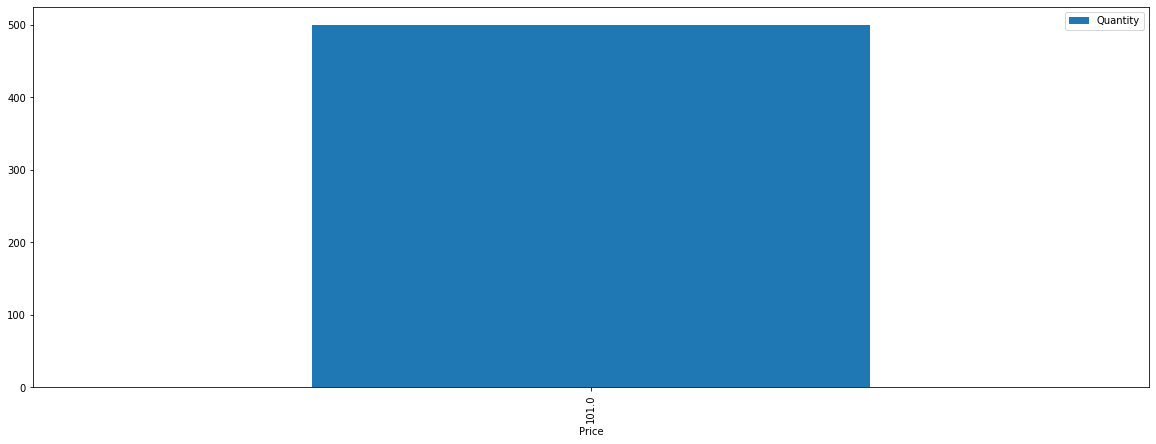

In [8]:
LOBstate = euronext.getLOBState()
tickSize =  float(euronext.getTickSize())
print(f'tick size : {tickSize}')
if type(LOBstate) == pd.DataFrame:
    if len(LOBstate) >0 :
        LOBstate = LOBstate.set_index('Price').sort_index()
        minPrice = LOBstate.index[0]
        maxPrice = LOBstate.index[-1]
        LOBstate = LOBstate.reindex(np.arange(minPrice, maxPrice+tickSize, tickSize))
        LOBstate.plot.bar(figsize=(20, 7))
    else:
        print('LOB is empty')
else:
    display(LOBstate)

# 4. Send orders

#### limit sell order @101 & limit buy order @99
Check the LOB state afterwards

In [9]:
# Send Orders
myself.send_sell_limit_order(quantity = 100,
                             price    = 101)

myself.send_buy_limit_order(quantity = 100,
                             price    = 100)

print('Sent orders : ')
display(pd.DataFrame.from_dict(myself.sentorders).T)

print('\n\nPending orders (Orders that are still in the LOB) : ')
display(pd.DataFrame.from_dict(myself.pendingorders).T)

print('\n\nExecuted Trades : ')
display(pd.DataFrame.from_dict(myself.executedtrades).T)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

#### match orders
Olivier will sell 50 at 100. A transaction will happen.

In [7]:
other.send_sell_limit_order(quantity = 50,
                             price    = 100)

print('Sent orders : ')
display(pd.DataFrame.from_dict(myself.sentorders).T)

print('\n\nPending orders (Orders that are still in the LOB) : ')
display(pd.DataFrame.from_dict(myself.pendingorders).T)

print('\n\nExecuted Trades : ')
display(pd.DataFrame.from_dict(myself.executedtrades).T)

Sent orders : 


,price,quantity,side,trader_id,type,order_id
0,101,100,ask,FDR,limit,NaN
1,100,100,bid,FDR,limit,NaN
2,NaN,NaN,ask,FDR,cancel,1
3,101,100,ask,FDR,limit,NaN
4,100,100,bid,FDR,limit,NaN




Pending orders (Orders that are still in the LOB) : 


,order_id,price,quantity,side,timestamp,trader_id,type
2,2,5,56,bid,1587323195861286500,FDR,limit
3,3,101,100,ask,1587323343948021900,FDR,limit
4,4,100,100,bid,1587323344606262400,FDR,limit




Executed Trades : 


,party1_id,party1_order_id,party1_side,party2_id,party2_order_id,party2_side,time,traded_price,traded_quantity
0,FDR,2,bid,Olivier,None,ask,1587323193230099000,100,50
1,FDR,4,bid,Olivier,None,ask,1587323346480829300,100,50


# 5. Modify orders

Rules for modification : 
1. If the order is already executed : no new order
2. Any order entered into the Central Order Book may be modified or cancelled prior to its execution. Any increase in the order quantity or change in the limit price shall cause the forfeiture of time priority. (Rule 4202/4 of Euronext)

Rules for cancellation :
1. If the order is already executed : no order cancellation

#### Cancel an order

In [8]:
print('\n\nPending orders (Orders that are still in the LOB) : ')
display(pd.DataFrame.from_dict(myself.pendingorders).T)



Pending orders (Orders that are still in the LOB) : 


,order_id,price,quantity,side,timestamp,trader_id,type
2,2,5,56,bid,1587323195861286500,FDR,limit
3,3,101,100,ask,1587323343948021900,FDR,limit
4,4,100,100,bid,1587323344606262400,FDR,limit


In [9]:
myself.cancelOrder(side     = 'ask', 
                   order_id = 1)

print('\n\nPending orders (Orders that are still in the LOB) : ')
display(pd.DataFrame.from_dict(myself.pendingorders).T)



Pending orders (Orders that are still in the LOB) : 


,order_id,price,quantity,side,timestamp,trader_id,type
2,2,5,56,bid,1587323195861286500,FDR,limit
3,3,101,100,ask,1587323343948021900,FDR,limit
4,4,100,100,bid,1587323344606262400,FDR,limit


#### modify an order

In [10]:
myself.modifyOrder(order_id     = 2, 
                   side         = 'bid',
                   new_price    = 5,
                   new_quantity = 56)

print('\n\nPending orders (Orders that are still in the LOB) : ')
display(pd.DataFrame.from_dict(myself.pendingorders).T)



Pending orders (Orders that are still in the LOB) : 


,order_id,price,quantity,side,timestamp,trader_id,type
2,2,5,56,bid,1587323195861286500,FDR,limit
3,3,101,100,ask,1587323343948021900,FDR,limit
4,4,100,100,bid,1587323344606262400,FDR,limit


# 6. Modify The LOB
One agent type (market) can reset the LOB, dump the tape, and modify the LOB properties 
#### Change tick size

In [11]:
euronext.setLOB_tickSize(0.1)

'DONE'

#### Remove all pending orders

In [8]:
euronext.resetLOB_PendingOrders()

'DONE'

#### Remove orders and transactions

In [13]:
euronext.resetLOB()

'DONE'